In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
experiment_dir = "/Users/sebastianlee/Dropbox/Documents/Research/Projects/catastrophic/run/results/2021-01-18-19-11-42"

In [3]:
readout_dirs = os.listdir(experiment_dir)

In [4]:
readout_dirs_fixed = [
    'readout_0.0',
    'readout_0.2',
    'readout_0.4',
    'readout_0.6',
    'readout_0.8',
    'readout_1.0'
]

In [5]:
dfs = {float(readout_dir.split("_")[1]): pd.read_csv(os.path.join(experiment_dir, readout_dir, "0", "network_log.csv")) for readout_dir in readout_dirs_fixed}

In [6]:
dfs.keys()

dict_keys([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

In [7]:
switch_errors_0 = {k: df.log_generalisation_error_0[14999] for k, df in dfs.items()}

In [8]:
final_errors_0 = {k: df.log_generalisation_error_0[29999] for k, df in dfs.items()}

In [9]:
switch_errors_1 = {k: df.log_generalisation_error_1[14999] for k, df in dfs.items()}

In [10]:
final_errors_1 = {k: df.log_generalisation_error_1[29999] for k, df in dfs.items()}

In [11]:
transfer = {k: df.log_generalisation_error_1[14999] - df.log_generalisation_error_1[29999] for k, df in dfs.items()}

In [12]:
transfer

{0.0: 2.6187277397748923,
 0.2: 2.6257666743886015,
 0.4: 2.6510068801555486,
 0.6: 2.6868668293950058,
 0.8: 2.728892733917389,
 1.0: 2.7771774168551406}

<ipython-input-13-2c2894f91ae9>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


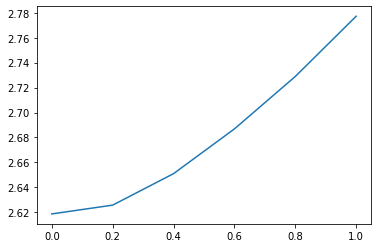

In [13]:
fig = plt.figure()
plt.plot(list(transfer.keys()), list(transfer.values()))
fig.show()

In [14]:
student_weight_paths = {float(readout_dir.split("_")[1]): {i: os.path.join(experiment_dir, readout_dir, "0", f"student_weights_{i}") for i in np.arange(0, 2995000, 5000)} for readout_dir in readout_dirs_fixed}

In [15]:
np.arange(0, 995000, 5000)

array([     0,   5000,  10000,  15000,  20000,  25000,  30000,  35000,
        40000,  45000,  50000,  55000,  60000,  65000,  70000,  75000,
        80000,  85000,  90000,  95000, 100000, 105000, 110000, 115000,
       120000, 125000, 130000, 135000, 140000, 145000, 150000, 155000,
       160000, 165000, 170000, 175000, 180000, 185000, 190000, 195000,
       200000, 205000, 210000, 215000, 220000, 225000, 230000, 235000,
       240000, 245000, 250000, 255000, 260000, 265000, 270000, 275000,
       280000, 285000, 290000, 295000, 300000, 305000, 310000, 315000,
       320000, 325000, 330000, 335000, 340000, 345000, 350000, 355000,
       360000, 365000, 370000, 375000, 380000, 385000, 390000, 395000,
       400000, 405000, 410000, 415000, 420000, 425000, 430000, 435000,
       440000, 445000, 450000, 455000, 460000, 465000, 470000, 475000,
       480000, 485000, 490000, 495000, 500000, 505000, 510000, 515000,
       520000, 525000, 530000, 535000, 540000, 545000, 550000, 555000,
      

In [16]:
student_weights = {k: {i: torch.load(w, map_location=torch.device('cpu')) for i, w in v.items()} for k, v in student_weight_paths.items()}

In [44]:
def feature_weight_diff_angle(weights0, weights1):
    feature_weights0 = weights0["_layers.0.weight"].numpy()
    feature_weights1 = weights1["_layers.0.weight"].numpy()
#     ind_dots = [np.dot(feature_weights0[i], feature_weights1[i]) / np.linalg.norm(feature_weights0[i]) / np.linalg.norm(feature_weights1[i]) for i in range(len(feature_weights0))]
#     mean_ind_dots = np.mean(ind_dots)
#     import pdb; pdb.set_trace()
    mean_diag = np.mean(np.diagonal(np.dot(feature_weights0, feature_weights1.T))) / 10
#     print(np.arccos(mean_diag))
    return mean_diag
#     return np.arccos(mean_ind_dots)
#     diffs = np.abs(feature_weights1 - feature_weights0)
#     mean_diff = np.mean(diffs)
#     return mean_diff

def feature_weight_diff_mse(weights0, weights1):
    feature_weights0 = weights0["_layers.0.weight"].numpy()
    feature_weights1 = weights1["_layers.0.weight"].numpy()
    diffs = np.sum((feature_weights1 - feature_weights0) ** 2) / np.sum(feature_weights0 ** 2)
    return diffs
    
def head_0_weight_diff(weights0, weights1):
    feature_weights0 = weights0["_heads.0.weight"].numpy()
    feature_weights1 = weights1["_heads.0.weight"].numpy()
    diffs = feature_weights1 - feature_weights0
    mean_diff = np.mean(diffs)
    return mean_diff

def head_1_weight_diff(weights0, weights1):
    feature_weights0 = weights0["_heads.1.weight"].numpy()
    feature_weights1 = weights1["_heads.1.weight"].numpy()
    diffs = feature_weights1 - feature_weights0
    mean_diff = np.mean(diffs)
    return mean_diff

In [45]:
student_weight_changes_angle = {}
student_weight_changes_mse = {}

for k, v in student_weights.items():
    weight_index_keys = list(student_weights[k].keys())
    weight_diffs_angle = {}
    weight_diffs_mse = {}
    s_step = 1500000
    for i in range(len(weight_index_keys)):
        i_diff_angle = feature_weight_diff_angle(
            weights0=student_weights[k][s_step], 
            weights1=student_weights[k][weight_index_keys[i]]
        )
        i_diff_mse = feature_weight_diff_mse(
            weights0=student_weights[k][s_step], 
            weights1=student_weights[k][weight_index_keys[i]]
        )
        weight_diffs_angle[weight_index_keys[i]] = i_diff_angle
        weight_diffs_mse[weight_index_keys[i]] = i_diff_mse
    student_weight_changes_angle[k] = weight_diffs_angle
    student_weight_changes_mse[k] = weight_diffs_mse

In [49]:
student_head_weight_magnitude_0 = {}
student_head_weight_magnitude_1 = {}

for k, v in student_weights.items():
    weight_index_keys = list(student_weights[k].keys())
    mags_0 = {}
    mags_1 = {}
    for i in range(len(weight_index_keys)):
        weights = student_weights[k][weight_index_keys[i]]
        h0_mag = np.linalg.norm(weights["_heads.0.weight"].numpy())
        h1_mag = np.linalg.norm(weights["_heads.1.weight"].numpy())
        mags_0[i] = h0_mag
        mags_1[i] = h1_mag
    student_head_weight_magnitude_0[k] = mags_0
    student_head_weight_magnitude_1[k] = mags_1

<ipython-input-51-131c02e1409e>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


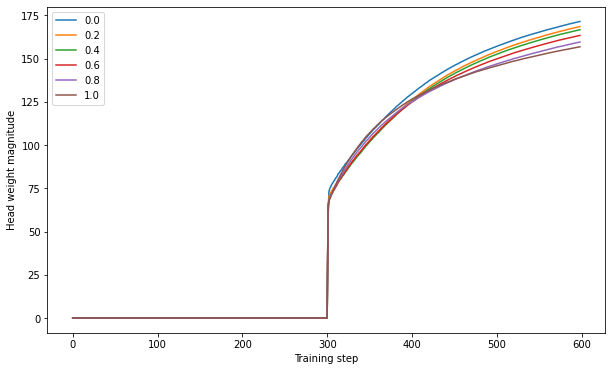

In [51]:
fig = plt.figure(figsize=(10,6))
for k, v in student_head_weight_magnitude_1.items():
    x_d = v.keys()
    y_d = list(v.values())
#     smooth_y = smooth_data(y_d, 80)
#     variances[k] = np.std(y_d)
#     plt.plot(range(len(smooth_y)), smooth_y, label=k)
    plt.plot(x_d, y_d, label=k)
    plt.xlabel("Training step")
    plt.ylabel("Head weight magnitude")
#     initial_changes[k] = [v[i] for i in np.arange(1500000, 1510000, 5000)]
    
plt.legend()
fig.show()

<ipython-input-52-e919cd515aa6>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


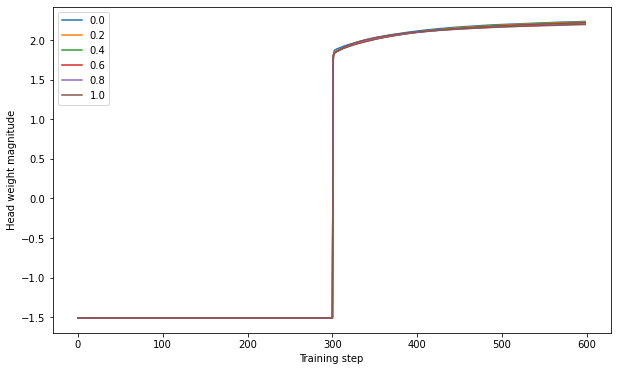

In [52]:
fig = plt.figure(figsize=(10,6))
for k, v in student_head_weight_magnitude_1.items():
    x_d = v.keys()
    y_d = list(v.values())
#     smooth_y = smooth_data(y_d, 80)
#     variances[k] = np.std(y_d)
#     plt.plot(range(len(smooth_y)), smooth_y, label=k)
    plt.plot(x_d, np.log10(y_d), label=k)
    plt.xlabel("Training step")
    plt.ylabel("Head weight magnitude")
#     initial_changes[k] = [v[i] for i in np.arange(1500000, 1510000, 5000)]
    
plt.legend()
fig.show()

<ipython-input-46-193462641301>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


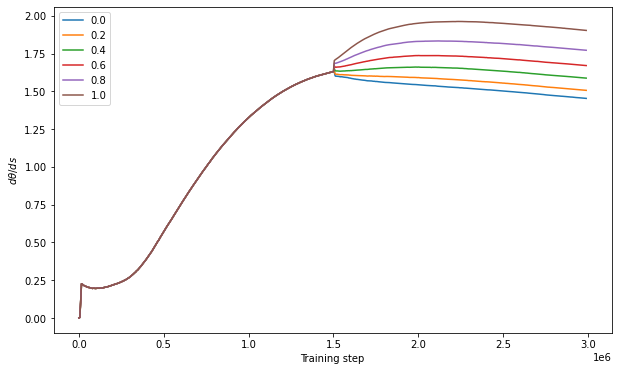

In [46]:
variances = {}
initial_changes = {}

fig = plt.figure(figsize=(10,6))
for k, v in student_weight_changes_angle.items():
    x_d = v.keys()
    y_d = list(v.values())
#     smooth_y = smooth_data(y_d, 80)
#     variances[k] = np.std(y_d)
#     plt.plot(range(len(smooth_y)), smooth_y, label=k)
    plt.plot(x_d, y_d, label=k)
    plt.xlabel("Training step")
    plt.ylabel(r"$d\theta/ds$")
#     initial_changes[k] = [v[i] for i in np.arange(1500000, 1510000, 5000)]
    
plt.legend()
fig.show()

In [53]:
from matplotlib import cm

<ipython-input-66-67af0cc29657>:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


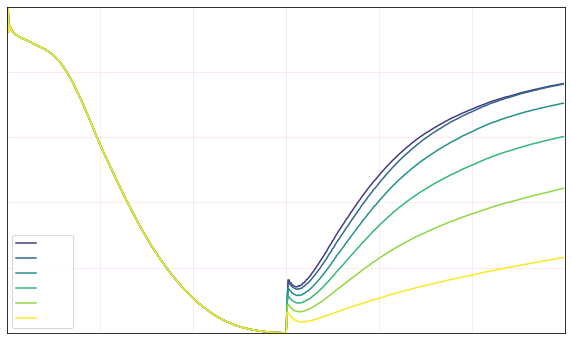

In [66]:
variances = {}
initial_changes = {}

color_map = cm.get_cmap("viridis")

fig = plt.figure(figsize=(10,6))
for i, (k, v) in enumerate(student_weight_changes_mse.items()):
    x_d = v.keys()
    y_d = list(v.values())
#     smooth_y = smooth_data(y_d, 80)
#     variances[k] = np.std(y_d)
#     plt.plot(range(len(smooth_y)), smooth_y, label=k)
    plt.plot(x_d, y_d, label="        ", color=color_map((i + 1) / len(student_weight_changes_mse)))
#     plt.xlabel("Training step")
#     plt.ylabel("MSE")
#     initial_changes[k] = [v[i] for i in np.arange(1500000, 1510000, 5000)]
plt.tick_params(
        axis='both',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False, # labels along the bottom edge are off
        left=False,
        labelleft=False
    ) 

plt.xlim(0, 3000000)
plt.ylim(0, 1)

plt.grid(b=True, which='major', color='r', linestyle='-', alpha=0.1)
plt.grid(b=True, which='minor', color='gray', linestyle='--', alpha=0.1)
    
plt.legend()
fig.show()
fig.savefig("feature_weight_movement_no_label.pdf", dpi=100, bbox_inches='tight', pad_inches=0)

In [266]:
switch_weights = {k: v[150000] for k, v in student_weights.items()}

In [250]:
switch_feature = switch_weights[0.0]['_layers.0.weight'].numpy()

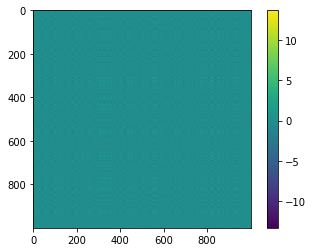

<Figure size 432x288 with 0 Axes>

In [255]:
fig = plt.figure()
plt.imshow(np.dot(switch_feature, switch_feature.T))
plt.colorbar()
fig = plt.figure()

In [271]:
from typing import List

def smooth_data(data: List[float], window_width: int) -> List[float]:
    """Calculates moving average of list of values

    Args:
        data: raw, un-smoothed data.
        window_width: width over which to take moving averags

    Returns:
        smoothed_values: averaged data
    """

    def _smooth(single_dataset):
        cumulative_sum = np.cumsum(single_dataset, dtype=float)
        cumulative_sum[window_width:] = (
            cumulative_sum[window_width:] - cumulative_sum[:-window_width]
        )
        smoothed_values = cumulative_sum[window_width - 1 :] / window_width
        return smoothed_values

    if all(isinstance(d, list) for d in data):
        smoothed_data = []
        for dataset in data:
            smoothed_data.append(_smooth(dataset))
    elif all(
        (isinstance(d, np.float32) or isinstance(d, int) or isinstance(d, np.int64))
        for d in data
    ):
        smoothed_data = _smooth(data)

    return smoothed_data

<ipython-input-202-358411dd9452>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


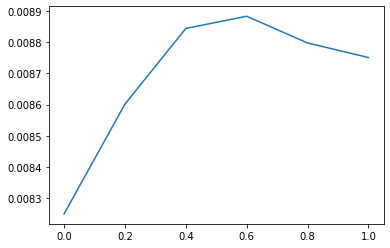

In [202]:
fig = plt.figure()
plt.plot(variances.keys(), variances.values())
fig.show()